In [ ]:
# Installing required packages
!pip3 install pyspark
!pip3 install findspark
!pip3 install pandas

In [3]:
import findspark
findspark.init()

In [4]:
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr,when

In [5]:
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

23/06/02 21:21:40 WARN Utils: Your hostname, Mazens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.22 instead (on interface en0)
23/06/02 21:21:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/02 21:21:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [20]:
egphotelbookings = pd.read_csv('egphotelbookings.csv')
sdf = spark.createDataFrame(egphotelbookings) 
sdf.printSchema()
sdf.show(10)
print('Rows',sdf.count()) 


root
 |-- Unnamed: 0: long (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_date_year: long (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: long (nullable = true)
 |-- arrival_date_day_of_month: long (nullable = true)
 |-- stays_in_weekend_nights: long (nullable = true)
 |-- stays_in_week_nights: long (nullable = true)
 |-- adults: long (nullable = true)
 |-- children: long (nullable = true)
 |-- babies: long (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: long (nullable = true)
 |-- previous_cancellations: long (nullable = true)
 |-- previous_bookings_not_canceled: long (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: long (nulla

In [21]:
print(len(sdf.columns))
print(sdf.count())


30
7326


In [24]:
sdf = sdf.dropDuplicates()

#here i am droping any column with more than 50 % pf null
threshold = sdf.count() * 0.5
sdf = sdf.drop(*[column for column in sdf.columns if sdf.where(col(column).isNull()).count() > threshold])

#here i am droping rows with more than 10 missing values
sdf = sdf.dropna(thresh=10)

#making new column with total nbr of guests
sdf = sdf.withColumn("total_guests", col("adults") + col("children") + col("babies"))

#making new column booking_canceled as a boolean to easily now if a booking got cancelled
#to be used in the ML models
sdf = sdf.withColumn("booking_canceled", col("is_canceled").cast("boolean"))

print(len(sdf.columns))
print(sdf.count())

32
7326


In [26]:
!pip3 install matplotlib
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.4 MB 815 kB/s eta 0:00:01
     |████████████████████████████████| 244 kB 248 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 869 kB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 510 kB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.0 MB/s eta 0:00:011
     |████████████████████████████████| 98 kB 3.4 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 293 kB 533 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


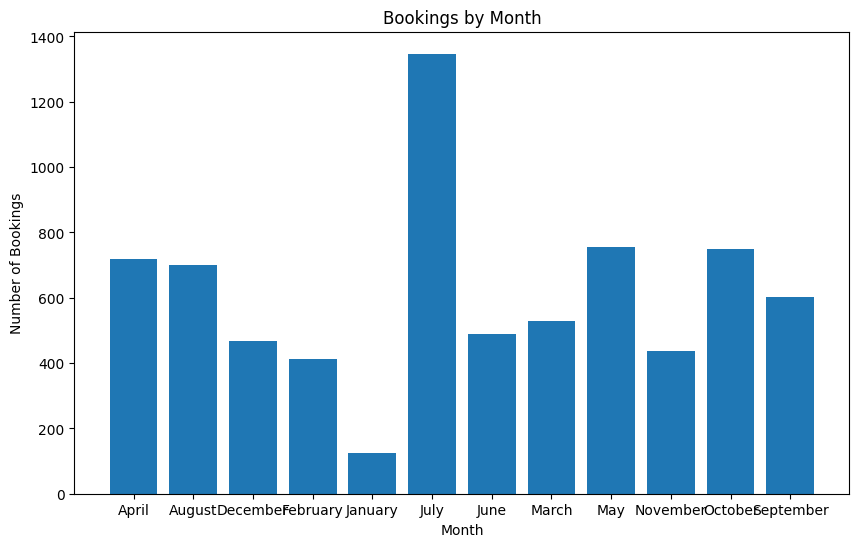

In [31]:
import matplotlib.pyplot as plt

#counting the number of bookings by every month to get the month with most traffic on bookings
monthly_bookings = sdf.groupBy("arrival_date_month").count().orderBy("arrival_date_month")

monthly_bookings_pd = monthly_bookings.toPandas()

# Plot 
plt.figure(figsize=(10, 6))
plt.bar(monthly_bookings_pd["arrival_date_month"], monthly_bookings_pd["count"])
plt.xlabel("Month")
plt.ylabel("Number of Bookings")
plt.title("Bookings by Month")
plt.show()


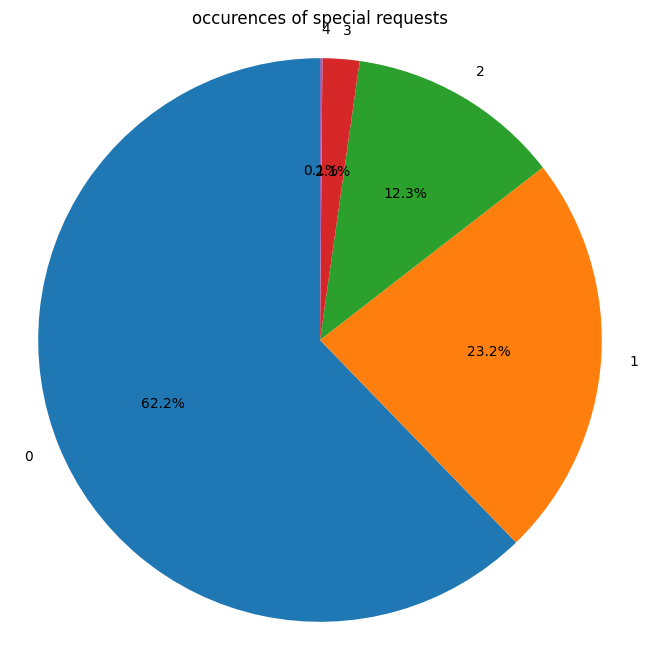

In [32]:
import seaborn as sns

# count the number of occurrences of every special request
special_requests = sdf.groupBy("total_of_special_requests").count().orderBy("total_of_special_requests")

special_requests_pd = special_requests.toPandas()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(special_requests_pd["count"], labels=special_requests_pd["total_of_special_requests"], autopct="%1.1f%%", startangle=90)
plt.title("occurences of special requests")
plt.axis("equal")
plt.show()


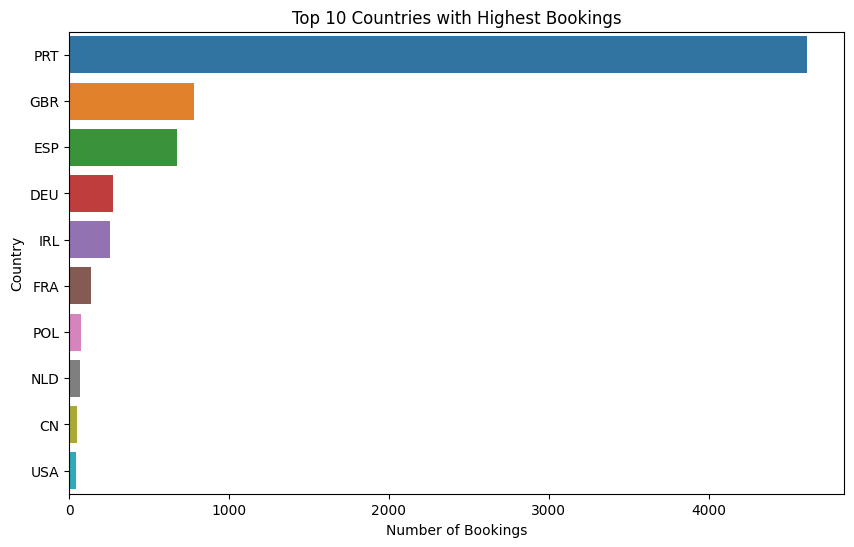

In [33]:
# counting the number of bookings in every country
country_bookings = sdf.groupBy("country").count().orderBy("count", ascending=False).limit(10)

country_bookings_pd = country_bookings.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="country", data=country_bookings_pd)
plt.xlabel("Number of Bookings")
plt.ylabel("Country")
plt.title("Top 10 Countries with Highest Bookings")
plt.show()
